This notebook will generate the plots from 'A quantitative description of light-limited cyanobacterial growth using flux balance analysis'\
To achieve this, the experimental Data from Zavrel 2019 is importat and used to fit a novel approach of simulating light absorption.
This fit is then used to predict and compare certain fluxes to experimentally optained values.

The notebook comes with data prepared, if you want to make sure to have the lates model version or don't trust the authors on the data set "download" to 'True' to get the data from e-life and save it to disk.

In [64]:
download = False
if download:
    import requests

In [65]:
if download:
    url = (
        "https://elifesciences.org/download/"
        "aHR0cHM6Ly9jZG4uZWxpZmVzY2llbmNlcy5"
        "vcmcvYXJ0aWNsZXMvNDI1MDgvZWxpZmUtND"
        "I1MDgtZmlnMi1kYXRhMS12Mi54bHN4/"
        "elife-42508-fig2-data1-v2.xlsx"
        "?_hash=Hh3ocah43An8im3VeACcZ%2F"
        "TxN1OLx58raFS1Bj%2Brtrw%3D"
    )
    filename = "data/elife-42508-fig2-data1-v2.xlsx"
    useragent = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"}
    data = requests.get(url, headers = useragent)
    with open(filename, 'wb') as file:
        file.write(data.content)

In [66]:
if download:
    url = (
        "https://itbgit.biologie.hu-berlin.de/hoeper/syn6803/-/raw/master/Synechocystis_6803.xml?ref_type=heads&inline=false"
    )
    filename = "model/Synechocystis_6803.xml"
    data = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(data.content)

Import the required local and python modules.

In [67]:
from modules.import_elife import DataImporter, Import_Theune
from modules.colors import Colors
from modules.import_model import import_model, split_rubisco
from modules.zavrel_FIT import pd_fitting, pd_fitting_w_resp
from modules.zavrel_FIT import plus_blue, fit_haldane, proteincontent
from modules.zavrel_FIT import photodamage_helper
from modules.add_glycogen import update_glycogen, update_prot_glyc
from modules.fit_glycogen_funcs import fit as fit_glyc
from modules.sens import Sensitivity_Calculator as SC

In [68]:
import numpy as np
import multiprocessing as mp
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import optimize as op
import os

Set up the CPUs for multiprocessing, this is necessary to run in binder.

In [69]:
binder = False
if binder:
    CPUs = 5
else:
    CPUs = len(os.sched_getaffinity(0)) - 2
    if CPUs > 1:
        CPUs = CPUs
    else:
        CPUs = 1

Import the Data from the excel or csv file.

In [70]:

zavrel = DataImporter(download=download)
BLUE_LIGHT = 27.5

Set up the plots:

In [71]:
HU = Colors()

sns.set_style('ticks')  # darkgrid, white grid, dark, white and ticks
# sns.set(rc={'axes.facecolor': HU.oldgreygreen + [.5]})
plt.rc('axes', titlesize=19)     # fontsize of the axes title
plt.rc('axes', labelsize=17)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes
plt.rc('lines', linewidth=3)     # width of the lines

def make_Axes(x):
    x.set_xlabel("Photon flux [$\\mu mol\\cdot m^{-2} s^{-1}$]")
    x.set_ylabel("Growth rate [$h^{-1}$]")
    x.set_xlim(0, 1100*1.1)
    x.set_ylim(0)


CM = 1/2.54  # convert cm to inch

savefigs = False
savepath = "plots/"
img_type = ".pdf"
img_size = np.array([6*CM, 4.5*CM])*2.2

Now we set up variables we'll need for our simulation and import the model.
Reaction IDs are saved into variables and data series are retrieved from the data class.
n_Data defines the granularity in terms of simulated data points 

In [72]:
PHOTON_ID = "EX_E1_ext_b"
NITRATE_ID = "EX_no3_e"
O2_ID = "EX_o2_e"
CO2_ID = "EX_co2_e"
EPS2 = "ATPSu"
EPS2_2 = "ATPS4rpp_1"
EPS1 = "FNOR"
NDH = ["PR000" + i for i in ["4", "6"]]  # , "7", "5"]]
gly = (True, 2)

LIGHTIN = zavrel.get("light")
GROWTHRATE = zavrel.get("growth")
O2 = zavrel.value("net O2 fba")
CO2 = zavrel.value("CO2 fba")
RESP = zavrel.value("dark resp fba")
GLYCOGEN = zavrel.get("glycogen")/zavrel.value("DW")
PROTEIN = zavrel.get("protein")/zavrel.value("DW")

n_Data = 100

new_syn = split_rubisco(import_model(
        'model/Synechocystis_6803.xml'
    ), 300/97)
# knock out cell wall h transport, to prevent "atp from nothing" production:
new_syn.reactions.PCXHtpp.lower_bound = 0

new_syn = update_glycogen(new_syn, 3.41)

photons = np.linspace(0, LIGHTIN[-1]*1.1, n_Data) + BLUE_LIGHT


glyc_fitted = fit_glyc(
    zavrel.get("light") + BLUE_LIGHT,
    zavrel.get("glycogen")/zavrel.get("DW")
)

Now we calculate the absorbed light with integration over the depth of the reactor  with lambert-beer.
Light at  depth z is I<sub>z</sub> = I<sub>0</sub> e<sup>-&epsilon; &rho;<sub>v</sub> z</sup>.
When integrated over the reactors depth we get J<sub>I</sub><sup>exp</sup> = $\frac{I_{abs}}{\rho_{A}}$ .
Blue photons are expected to be absorbed at the same rate.
Light absorption per gCDM and time is calculated for 0, 100 and an expected value of 66% of blue light utilization:

In [73]:
def calc_light(blue: float) -> np.array:
    light_calc = (
        (
            zavrel.get("light cap with error")
            +
            (
                BLUE_LIGHT * zavrel.get("light cap with error")
                /
                zavrel.get("light with error") * blue
            )
        )
        /
        (zavrel.get("DW with error") * 0.02) * (60*60) / 1000
    )
    return light_calc


light_calc_with_error_b0 = calc_light(0)
light_calc_with_error_b100 = calc_light(1)
light_calc_with_error = calc_light(.66)

Let's start\
These parameters were fitted to the experimental data: p<sub>max</sub>, &alpha;, &alpha;<sub>b</sub>, photodamage, respiration coefficient and nGAM.
The simulation results were fitted to the data from Zavrel et al. for Growth Rate and Dark Respiration.

In [74]:
(kl, alpha, alpha2, kd, mehl, maint) = (
    115.68859567020586, 
    0.130680048776114, 
    0.6827019432157868, 
    6.986416566909339, 
    9.399551400181362, 
    1.6383766806574447
)
print(f"Alpha: {alpha}")
print(f"Alpha2: {alpha2}")
print(f"K_L: {kl}")
print(f"k_d: {kd}")
print(f"nGAM: {maint}\nresp: {mehl}")

Alpha: 0.130680048776114
Alpha2: 0.6827019432157868
K_L: 115.68859567020586
k_d: 6.986416566909339
nGAM: 1.6383766806574447
resp: 9.399551400181362


Then add the value for respiration to the model:

In [75]:
resp_rxns = [
    new_syn.reactions.get_by_id(X) for X in [
        "CYOOum", "PR0011"
    ]
]
use_sum = sum([x.flux_expression for x in resp_rxns])
some_flux = new_syn.problem.Constraint(
    use_sum - mehl/100 * new_syn.reactions.PR0043.flux_expression,
    lb=0,
    ub=1000,
    name="respiration"
)
new_syn.add_cons_vars([some_flux])

With &alpha; we fitted a factor to convert irradiated photons per area to absobed photons per gCDM (per time). We can compare this linear fit with the absorbed photons that we calculated earlier. For demsonstrating purposes, let's add the blue photons with an efficiency of 0-100%:

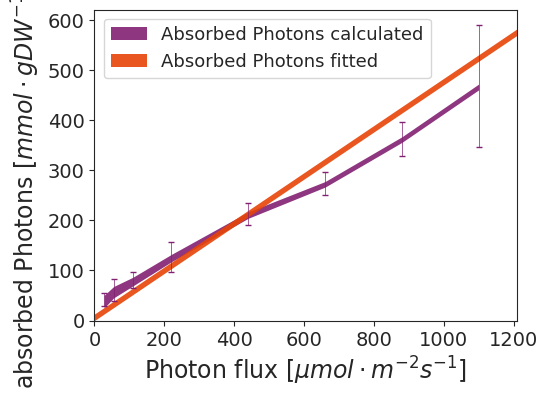

In [76]:
show_points = False

fig, ax = plt.subplots(figsize=img_size)
ax.fill_between(
    LIGHTIN,
    [p.n for p in light_calc_with_error_b0],
    [p.n for p in light_calc_with_error_b100],
    facecolor=HU.violet+[0.9], linewidth=0,
    label="Absorbed Photons calculated"
)
ax.fill_between(
    photons-BLUE_LIGHT,
    alpha*3.6*(photons-BLUE_LIGHT), alpha*3.6*(photons),
    facecolor=HU.orange+[0.9], linewidth=0,
    label="Absorbed Photons fitted"
)
ax.errorbar(
    LIGHTIN, [p.n for p in light_calc_with_error],
    [p.s for p in light_calc_with_error],
    fmt="none", elinewidth=.5, capsize=2, ecolor=HU.violet
)
if show_points:
    ax.plot(
        LIGHTIN, p_calc := [p.n for p in light_calc_with_error],
        "o", color=HU.violet,
        label="Absorbed Photons calculated"
    )
    ax.plot(
        LIGHTIN,
        alpha*3.6*(LIGHTIN+alpha2*BLUE_LIGHT), "o",
        color=HU.orange,
        label="Absorbed Photons fitted"
    )
make_Axes(ax)
ax.legend()
ax.set_ylabel("absorbed Photons [$mmol\\cdot gDW^{-1} h^{-1}$]")
# ax.set_xlabel("Photons irradiated [$µE\\cdot m^{-2} s^{-1}$]")

plt.tight_layout(pad=0.3)
fig.show()
if savefigs:
    fig.savefig(savepath+"photons"+img_type, bbox_inches='tight')

The defaul biomass composition of the model can be visualized regarding the makrocomponents. A major part is composed of protein followed by RNA and lipids:

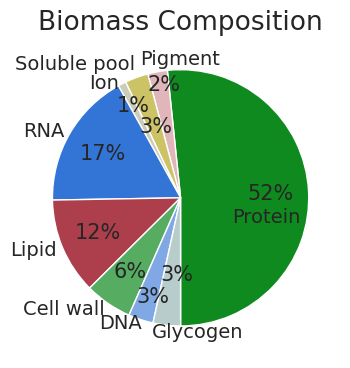

In [77]:

bof = new_syn.reactions.BM0009

BM_DICT = {
    "BM_comp": [
        met.name.replace(" component of biomass_cyt", "")
        for met in bof.reactants
        if met.id not in [
            "atp_c", "h2o_c"
        ]
    ],
    "percent": [
        bof.get_coefficient(met) * -100
        for met in bof.reactants
        if met.id not in [
            "atp_c", "h2o_c"
        ]
    ],
    "colors": [
        HU.oldgreen,
        HU.oldred + [.3],
        HU.oldsand,
        HU.oldgreygreen,
        HU.oldblue + [.8],
        HU.oldred + [.8],
        HU.oldgreen + [.7],
        HU.oldblue + [.5],
        HU.oldgreyblue
    ]
}

# BM_FRAME = pd.DataFrame(BM_DICT).set_index("BM_comp")

percents = BM_DICT["percent"]
labels = BM_DICT["BM_comp"]
colors = BM_DICT["colors"]
fig, ax = plt.subplots(figsize=(10*CM, 10*CM), tight_layout=True)
patches, texts, autotexts = ax.pie(
percents, labels=labels,
colors=colors,
autopct='%1.0f%%', startangle=270,
pctdistance=0.7, labeldistance=1.05
)
ax.set_title("Biomass Composition")
texts[0]._x -= 0.65
texts[0]._y -= 0.2
texts[1]._x += 0.5
texts[1]._y += 0.05
texts[2]._x += 0.01
texts[2]._y += 0.06
texts[3]._y -= 0.04
texts[7]._x += 0.02
texts[7]._y += 0.02
texts[8]._x += 0.6
autotexts[1]._y += 0.2
autotexts[2]._x += 0.05
autotexts[2]._y -= 0.1
autotexts[3]._x -= 0.05
autotexts[3]._y += 0.1
autotexts[7]._y -= 0.1
autotexts[8]._x += 0.05
autotexts[8]._y += 0.1
fig.show()

For more accurate predictions the biomass is updated prior to each simulation to represent the measured values for glycogen and protein content in the cell.\
Other components are scaled relative to their share of the biomass.\
The Biomass composition changes accordingly, dependent on the irradiated light intensity:

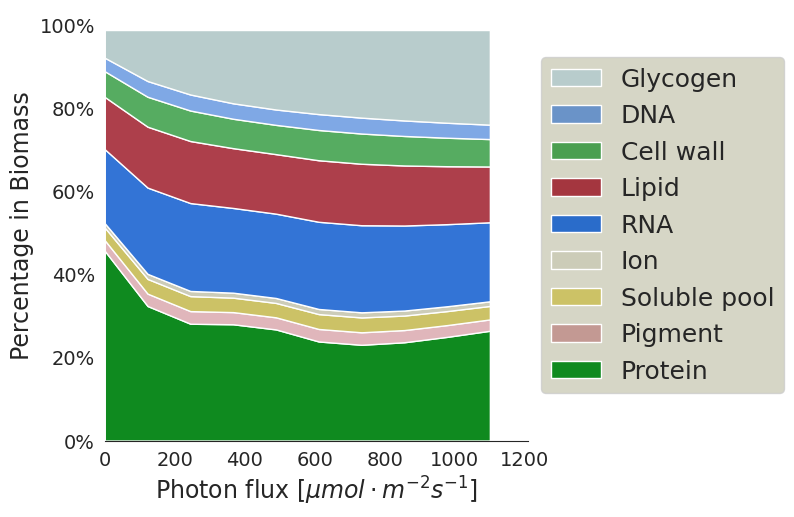

In [78]:
stackes = {}
with new_syn:
    for ind in photons[::10]:
        new_syn = update_prot_glyc(
            new_syn, proteincontent(ind), glyc_fitted(ind)
        )
        bof = new_syn.reactions.BM0009
        stackes[ind] = {
            "BM_comp": [
                met.name.replace(" component of biomass_cyt", "")
                for met in bof.reactants
                if met.id not in [
                    "atp_c", "h2o_c"
                ]
            ],
            "percent": [
                bof.get_coefficient(met) * -100
                for met in bof.reactants
                if met.id not in [
                    "atp_c", "h2o_c"
                ]
            ],
            "colors": [
                HU.oldgreen,
                HU.oldred + [.3],
                HU.oldsand,
                HU.oldgreygreen,
                HU.oldblue + [.8],
                HU.oldred + [.8],
                HU.oldgreen + [.7],
                HU.oldblue + [.5],
                HU.oldgreyblue
            ]
        }

    with sns.axes_style(
        'white',
        rc={
            'figure.facecolor': HU.oldgreygreen + [0],
            'axes.facecolor': HU.oldgreygreen + [0]
        }
    ):
        fig, ax = plt.subplots(figsize=[7.87, 5.1])
        ax.stackplot(
            photons[::10]-BLUE_LIGHT,
            [stackes[i]["percent"][0] for i in photons[::10]],
            [stackes[i]["percent"][1] for i in photons[::10]],
            [stackes[i]["percent"][2] for i in photons[::10]],
            [stackes[i]["percent"][3] for i in photons[::10]],
            [stackes[i]["percent"][4] for i in photons[::10]],
            [stackes[i]["percent"][5] for i in photons[::10]],
            [stackes[i]["percent"][6] for i in photons[::10]],
            [stackes[i]["percent"][7] for i in photons[::10]],
            [stackes[i]["percent"][8] for i in photons[::10]],
            labels=stackes[LIGHTIN[0]]["BM_comp"],
            colors=stackes[LIGHTIN[0]]["colors"]
        )
        make_Axes(ax)
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"])
        ax.set_ylabel("Percentage in Biomass")
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(
            handles[::-1], labels[::-1],
            loc="center left", bbox_to_anchor=(1, .5),
            fontsize=18
        )

        sns.despine(left=True)
        plt.tight_layout(pad=0.3)
fig.show()
if savefigs:
    fig.savefig(savepath+"BM_stacked"+img_type)

Now we'll start simulating.\
These can take quite some time. If you want faster results, lower the N_DATA value ta have less data points (and less smooth plots)\
Let's start with stoichiometric gwoth:\
Here, only the absorbed light, according to the equation $J_I = \alpha \, \left( I_0 + \alpha_b \, I_b \right)$ is considered.

In [79]:
# N_DATA = 1000
# photons = np.linspace(0, LIGHTIN[-1]*1.1, N_DATA) + blue_light

with mp.Pool(CPUs) as pool:
    with new_syn:
        stoich_gro = np.array(pool.starmap(
                photodamage_helper,
                (
                    (
                        new_syn,
                        PHOTON_ID,
                        "BM0009",
                        p*-1,
                        10**100,
                        0,
                        alpha, alpha2, 0,
                        gly, maint
                    )
                    for p in photons
                )
            ))

Let's plot it and compare it to the actual data:

MAX stoich yield:  1.83906546855235


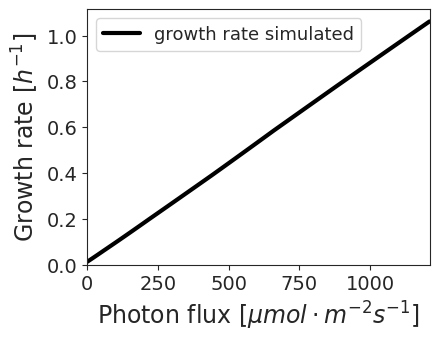

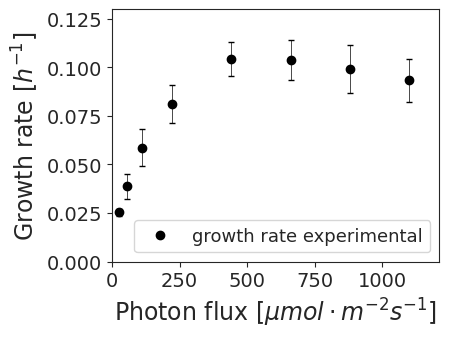

In [80]:
fig, ax = plt.subplots(figsize=img_size*.85)
ax.plot(
    photons-BLUE_LIGHT, stoich_gro, 'k-', label="growth rate simulated"
)
make_Axes(ax)
ax.legend()
fig.show()
if savefigs:
    fig.savefig(savepath + "growth"+img_type)
fig1, ax1 = plt.subplots(figsize=img_size*.85)
ax1.plot(LIGHTIN, GROWTHRATE, "ko", label="growth rate experimental")
ax1.errorbar(
    LIGHTIN, GROWTHRATE, zavrel.error("growth"),
    fmt="none", elinewidth=.5, capsize=2, ecolor="k"
)
make_Axes(ax1)
ax1.set_ylim(0, 0.13)
ax1.legend(loc="lower right")

plt.tight_layout(pad=0.3)
fig1.show()
if savefigs:
    fig1.savefig(savepath + "growth_exp"+img_type)

print(
    "MAX stoich yield: ",
    max(np.array(stoich_gro)/plus_blue(photons, alpha, alpha2)*1000)
)

The experimental data was also used to fit a haldane function $\mu = \mu^* \frac{I_0}{ka + I_0 + \gamma * \frac{{I_0}^2}{ka}}$

We can use the fitted parameters &mu;<sup>*</sup>, k<sub>a</sub> and &gamma; to simulate the data with a haldane function:

In [81]:
(mumax, ka, gamma) = 0.17196064666583916, 196.3951011185911, 0.11320312139220756
print(f"MuMax: {mumax}\nKa: {ka}\nGamma: {gamma}")

MuMax: 0.17196064666583916
Ka: 196.3951011185911
Gamma: 0.11320312139220756


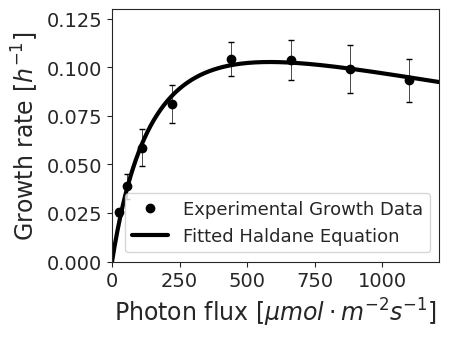

In [82]:
fig, ax = plt.subplots(figsize=img_size*.85)
ax.plot(
    LIGHTIN, GROWTHRATE, "ko",
    label="Experimental Growth Data"
)
ax.plot(
    ins := np.linspace(0, LIGHTIN[-1]*1.1, 1000),
    fit_haldane(ins, mumax, ka, gamma),
    "k", label="Fitted Haldane Equation"
)
ax.errorbar(
    LIGHTIN, GROWTHRATE, zavrel.error("growth"),
    fmt="none", elinewidth=.5, capsize=2, ecolor="k"
)
ax.set_ylim(0, 0.13)
make_Axes(ax)
ax.legend()

plt.tight_layout(pad=0.3)
if savefigs:
    fig.savefig(savepath+"haldane"+img_type)

Additionally the model was fitted to the data but photodamage was ignored:\
Effective light utilization is calculated with the equation $J^*_I  = \eta(J_I) \cdot J_I = \frac{K_L}{K_L + J_I} \, J_I$

In [83]:


(kl_nd, alpha_nd, alpha2_nd, kd_nd) = 80.88778385140277, 0.13421491844415123, 0.5684435217300496, 0

print(kl_nd, alpha_nd, alpha2_nd, kd_nd)

with mp.Pool(CPUs) as pool:
    gro_nd = pool.starmap(
            photodamage_helper,
            (
                (
                    new_syn,
                    PHOTON_ID,
                    "BM0009",
                    p*-1,
                    kl_nd,
                    kd_nd,
                    alpha_nd,
                    alpha2_nd, 0,
                    gly, maint
                )
                for p in photons
            )
        )


80.88778385140277 0.13421491844415123 0.5684435217300496 0


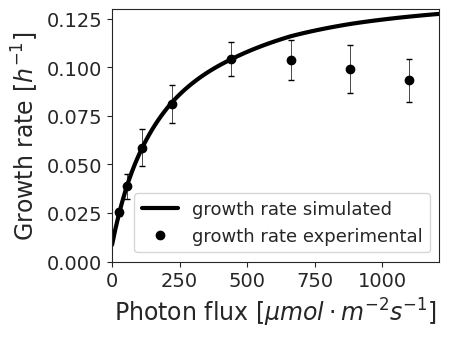

In [84]:

fig, ax = plt.subplots(figsize=img_size*.85)
ax.plot(photons-BLUE_LIGHT, gro_nd, "k", label="growth rate simulated")
ax.plot(LIGHTIN, GROWTHRATE, "ko", label="growth rate experimental")
ax.errorbar(
    LIGHTIN, GROWTHRATE, zavrel.error("growth"),
    fmt="none", elinewidth=.5, capsize=2, ecolor="k"
)
make_Axes(ax)
ax.legend()
ax.set_ylim(0, 0.13)

plt.tight_layout(pad=0.3)
fig.show()
if savefigs:
    fig.savefig(savepath + "growth_monod"+img_type)

Now simulate with all parameters and grep the values for growthrate, O<sub>2</sub>, CO<sub>2</sub> and NO<sub>3</sub>


In [85]:
with mp.Pool(CPUs) as pool:
    groo2co2 = pool.starmap(
        photodamage_helper,
        (
            (
                new_syn,
                PHOTON_ID,
                ["BM0009", O2_ID, CO2_ID, NITRATE_ID],
                p*-1,
                kl,
                kd,
                alpha,
                alpha2, 0,
                gly, maint
            )
            for p in photons
        )
    )
    gro = np.array([f[0] for f in groo2co2])
    o2 = np.array([f[1] for f in groo2co2])
    co2 = np.array([f[2] for f in groo2co2])
    no3 = np.array([f[3] for f in groo2co2])

Plot growth rate:

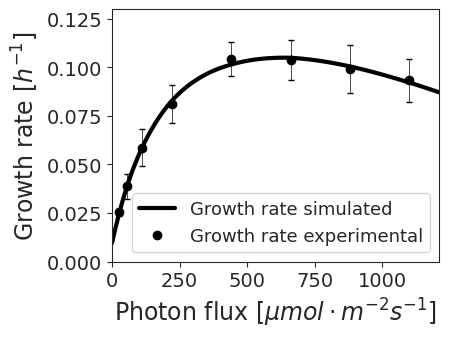

In [86]:
fig, ax = plt.subplots(figsize=img_size*.85)

p1 = ax.plot(photons-BLUE_LIGHT, gro, "k", label="Growth rate simulated")
p2 = ax.plot(LIGHTIN, GROWTHRATE, "ko", label="Growth rate experimental")
ax.errorbar(
    LIGHTIN, GROWTHRATE, zavrel.error("growth"),
    fmt="none", elinewidth=.5, capsize=2, ecolor="k"
)
make_Axes(ax)
ax.legend()
ax.set_ylim(0, 0.13)

plt.tight_layout(pad=0.3)
fig.show()
if savefigs:
    fig.savefig(savepath + "growth_monod_pd"+img_type)

Plot O<sub>2</sub>\
The O<sub>2</sub> export flux is retrieved from the simulation solutions and are not subject to fitting.\
The experimental data is overestimated in the simulations. But the experiments negelected loss of O<sub>2</sub> to headspace.\
The grey points show the experimental results plus a realistic 12% loss.

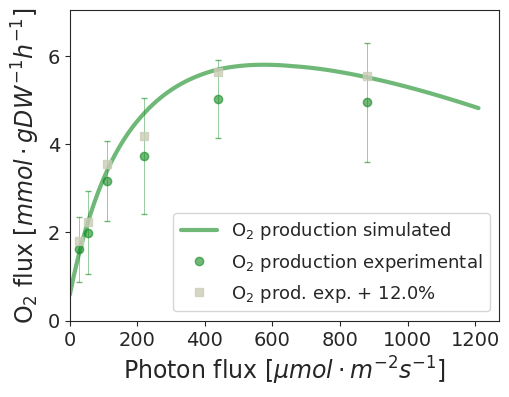

In [87]:
fig, ax = plt.subplots(figsize=img_size)  # figsize=(17.32*CM, 13*CM))
p3 = ax.plot(
    photons-BLUE_LIGHT, o2, color=HU.oldgreen + [.6],
    label="O$_2$ production simulated"
)
p4 = ax.plot(
    LIGHTIN, O2, "o", color=HU.oldgreen + [.6],
    label="O$_2$ production experimental"
)
ax.errorbar(
    LIGHTIN, O2, zavrel.error("O2 fba"),
    fmt="none", elinewidth=.5, capsize=2, ecolor=HU.oldgreen + [.6]
)
O2_CORRECTION = 1.12
p5 = ax.plot(
    LIGHTIN, O2 * O2_CORRECTION, "s", color=HU.oldgreygreen + [.8],
    label=f"O$_2$ prod. exp. + {round((O2_CORRECTION-1)*100, 0)}%"
)
O2_CORRECTION = 1
p = p3 + p4 + p5
labels = [lab.get_label() for lab in p]
ax.legend(p, labels)
ax.set_ylim(0, 7.05)
ax.set_xlim(0)
ax.set_xlabel("Photon flux [$\\mu mol\\cdot m^{-2} s^{-1}$]")
ax.set_ylabel(r"O$_2$ flux [$mmol\cdot gDW^{-1}h^{-1}$]")

plt.tight_layout(pad=0.3)
fig.show()
if savefigs:
    fig.savefig(savepath + "growth_plus_o2"+img_type)

We also look at the yield, i.e. the biomass production divided by the irradiated photons. For the experimental values we span a range from 0-100% usage of blue photons.

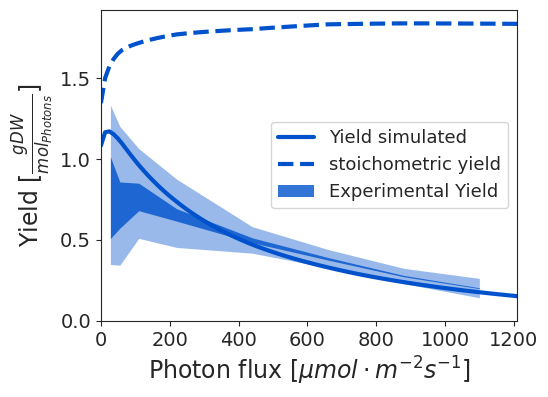

In [88]:
fig, ax = plt.subplots(figsize=img_size)  # figsize=(17.32*CM, 13*CM))
ax.plot(
    photons-BLUE_LIGHT,
    gro/plus_blue(photons, alpha, alpha2)*1000,
    color=HU.oldblue, label="Yield simulated"
)
ax.plot(
    photons-BLUE_LIGHT,
    stoich_gro/plus_blue(photons, alpha, alpha2)*1000,
    "--", color=HU.oldblue, label="stoichometric yield"
)
make_Axes(ax)
ax.set_ylim(0)
ax.set_ylabel("Yield [$\\frac{gDW}{mol_{Photons}}$]")
ax.legend()

ax.fill_between(
    zavrel.get("light"),
    np.array([
        -y.s for y in
        zavrel.get(
            "growth with error"
        )/light_calc_with_error_b100*1000
    ]) +
    GROWTHRATE/np.array([i.n for i in light_calc_with_error_b100])*1000,
    np.array([
        y.s for y in
        zavrel.get(
            "growth with error"
        )/light_calc_with_error_b0*1000
    ]) +
    GROWTHRATE/np.array([i.n for i in light_calc_with_error_b0])*1000,
    facecolor=HU.oldblue+[0.4], linewidth=0
)
ax.fill_between(
    zavrel.get("light"),
    GROWTHRATE/np.array([i.n for i in light_calc_with_error_b0])*1000,
    GROWTHRATE/np.array([i.n for i in light_calc_with_error_b100])*1000,
    color=HU.oldblue+[0.8], linewidth=0,
    label=("Experimental Yield")
)
ax.legend()

plt.tight_layout(pad=0.3)
plt.show()
if savefigs:
    fig.savefig(savepath + "yield_int_light"+img_type)

It is also possible to look at fluxes regarding the redox balance in the cells. We want to analyse the ATP/NAPDH production ratio for the different light intensities. Therefore we perform FVA for the ATPases and Ferredoxin---NADP<sup>+</sup> reductase

In [89]:
with mp.Pool(CPUs) as pool:
    with new_syn:
        photons_100 = np.linspace(0, LIGHTIN[-1]*1.1, 100) + BLUE_LIGHT
        ps2_var = pool.starmap(
            photodamage_helper,
            (
                (
                    new_syn,
                    PHOTON_ID,
                    EPS2,
                    p*-1,
                    kl,
                    kd,
                    alpha, alpha2, 0,
                    gly, maint, True
                )
                for p in photons_100
            )
        )
        ps2_var_2 = pool.starmap(
            photodamage_helper,
            (
                (
                    new_syn,
                    PHOTON_ID,
                    EPS2_2,
                    p*-1,
                    kl,
                    kd,
                    alpha, alpha2, 0,
                    gly, maint, True
                )
                for p in photons_100
            )
        )
        ps1_var = pool.starmap(
            photodamage_helper,
            (
                (
                    new_syn,
                    PHOTON_ID,
                    EPS1,
                    p*-1,
                    kl,
                    kd,
                    alpha, alpha2, 0,
                    gly, maint, True
                )
                for p in photons_100
            )
        )

The sum of max and min values from the 2 atpases is constant, so only one sum is considered.
The variability area for the atp/nadph ratio is plotted and compared to the data from Theune et al. 2021

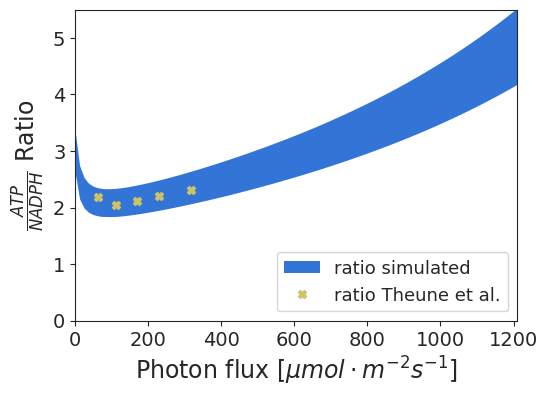

In [90]:

ps1min = np.array([tup[0] for tup in ps1_var])
ps1max = np.array([tup[1] for tup in ps1_var])

ps2 = np.array([tup[1]+tip[0] for tup, tip in zip(ps2_var, ps2_var_2)])

fig, ax = plt.subplots(figsize=img_size)
ax.fill_between(
    photons_100-BLUE_LIGHT,
    3*ps2/ps1max,
    3*ps2/ps1min,
    facecolor=HU.oldblue+[.8], label="ratio simulated",
    linewidth=0  # edgecolor=HU.oldblue
)
theune = Import_Theune()
ax.plot(
    theune.X, theune.ratio,
    "X", color=HU.oldsand,
    label="ratio Theune et al."
)
make_Axes(ax)
ax.set_ylim(0, 5.5)
ax.set_ylabel("$\\frac{ATP}{NADPH}$ Ratio")
ax.legend(loc="lower right")

plt.tight_layout(pad=0.3)
fig.show()
if savefigs:
    fig.savefig(savepath + "atpnadph"+img_type)

In the end, we can have a look at the Sensitivity of the parameters, i.e. how does a slight alternation of the parameters change the growth result?
Sensitivity is calculated as $C_k^{\mu} = \frac{\Delta\mu}{\mu} / \frac{\Delta k}{k} = 
    \frac{k}{\mu} \frac{\Delta\mu}{\Delta k}$

In [91]:
sens_calc = SC(
    new_syn,
    kd,
    kl,
    alpha,
    alpha2,
    maint
)

In [92]:
phots = np.linspace(0, 1100, 100)
with mp.Pool(CPUs) as pool:
    sensitivities = pool.map(sens_calc.calc_sens, phots)

/home/hoeper/Models/cyano_models/growth_curves_fba/syn-growth-fit/modules/sens.py:126: RuntimeWarning: invalid value encountered in scalar divide
  (self.ub_params_list[i][i] - self.lb_params_list[i][i])


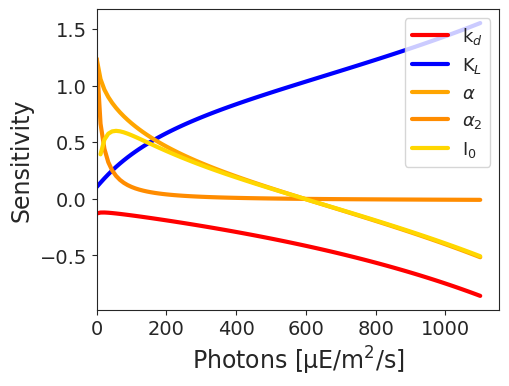

In [93]:
parastrings = {
    "kd": ("k$_d$", "red"),
    "kl": ("K$_L$", "blue"),
    "a": ("$\\alpha$", "orange"),
    "a2": ("$\\alpha_2$", "darkorange"),
    "I0": ("I$_0$", "gold")
}
fig, ax = plt.subplots(figsize=img_size)
for p in parastrings:
    ax.plot(
        phots, [dic[p] for dic in sensitivities],
        color=parastrings[p][1], label=parastrings[p][0]
    )

ax.set_ylabel("Sensitivity")
ax.set_xlabel("Photons [µE/m$^2$/s]")
ax.set_xlim(0)
ax.legend()
fig.show()
if savefigs:
    fig.savefig(savepath + "sens_all" + img_type, bbox_inches='tight')